In [1]:
import pandas as pd
import py2neo as pn
import time
import matplotlib.pyplot as plt
import datetime

In [62]:
neo4j_url = 'bolt://localhost:11003'
user = 'neo4j'
pwd = '0000'
# in advance, you have to manually change the active database with respect to the volume you want to query
# in neo4j.conf set dbms.memory.max_heap_size = 4G
data={}
# dictionary for dataframes to reduce the time of calculation
EntityIdAttributeNameDB='n.user_id'
# you have to change this according to how the attribute corresponding to entity identifier is called in your dataset

In [64]:
def conn():
    """
    Connect to Neo4j

    Parameters: None

    Returns: py2neo.database.Graph: A Py2neo Graph object representing the connection to the Neo4j graph database
    """
    try:
        # connect DB
        return pn.Graph(neo4j_url,auth=(user, pwd))
    except Exception as error:
        print('Caught this error: ' + repr(error))

In [65]:
def GetTimeline(graph, EntityLabel):
    """
    Retrieve the start and end times for a timeline of entities with a given label.

    Parameters:
    graph (py2neo.database.Graph): A Py2neo Graph object representing the connection to the Neo4j graph database.
    EntityLabel (str): A string that specifies the label of the entities for which the timeline is to be retrieved.

    Returns:
    pandas.DataFrame: A Pandas DataFrame with two columns, "min" and "max", which contain the minimum start time and maximum end time, respectively, of the entities with the specified label in the graph database.
    """
    # query for timeline of entities with given label

    # query for timeline of entities with given label
    query_max_min = f"MATCH (n: {EntityLabel})" + \
                    " RETURN min(n.startvalidtime) as min, max(n.endvalidtime) as max"
    return graph.run(query_max_min).to_data_frame()

In [66]:
def SplitTimeline(TimeUnit, result_min_max=None, IntervalStartUnit=None, IntervalEndUnit=None):
    """
    Splits a timeline into intervals of a given time unit.

    Parameters:
    TimeUnit (str): A string that specifies the time unit used for splitting the timeline, e.g. "D" for days, "M" for months, etc.
    result_min_max (pandas.DataFrame, optional): A Pandas DataFrame with two columns, "min" and "max", which contain the minimum start time and maximum end time, respectively, of the timeline. If not provided, this function will assume that the entire timeline should be split.
    IntervalStartUnit (str, optional): A string that specifies the start time of the interval to be split. If provided, this function will split the interval between this time and the time specified in IntervalEndUnit.
    IntervalEndUnit (str, optional): A string that specifies the end time of the interval to be split. If provided, this function will split the interval between this time and the time specified in IntervalStartUnit.

    Returns:
    pandas.DatetimeIndex: A DatetimeIndex object containing the start times of each interval in the timeline, split according to the specified time unit.
    """
    if (IntervalStartUnit is None) & (IntervalEndUnit is None):
        tmin = result_min_max["min"][0]
        tmax = result_min_max["max"][0]
        # split the timeline with given time unit
        return pd.date_range(tmin, tmax, freq=TimeUnit)
    else:
        start_interval_datetime = pd.to_datetime(IntervalStartUnit)
        end_interval_datetime = pd.to_datetime(IntervalEndUnit)
        end_interval_end_datetime = end_interval_datetime + pd.Timedelta(days=1)
        return pd.date_range(start_interval_datetime, end_interval_end_datetime, freq=TimeUnit)

In [67]:
def DegreeInUnit(graph, UnitStartTime, UnitEndTime, EntityLabel, RelationshipTypeStr=None):
    """
    Calculate the sum of relationships with given relationship type (if specified)existent within the given time unit as the degree of entities with the given label.

    Parameters:
    - graph: The Neo4j graph object on which the query is run.
    - UnitStartTime: The start time of the unit for which the degree is to be calculated.
    - UnitEndTime: The end time of the unit for which the degree is to be calculated.
    - EntityLabel: The label of the entity for which the degree is to be calculated.
    - RelationshipTypeStr (optional): The type of relationship between the entities. If not provided, all relationships are considered.

    Returns:
    - A Pandas DataFrame object containing the EntityId and DegreeEntity columns, where EntityId is the ID of the entity and DegreeEntity is the degree of the entity in the given time unit.
    """
    # query for degree in one unit, maybe with relationships chosen
    query_degree = f"""MATCH (n:{EntityLabel}){"-" + f"[r:{RelationshipTypeStr}]" if RelationshipTypeStr else "-[r]"}-() WHERE datetime(r.endvalidtime) >= datetime('{UnitStartTime}') AND datetime(r.startvalidtime) < datetime('{UnitEndTime}') RETURN {EntityIdAttributeNameDB} AS EntityId, count(r) AS DegreeEntity"""
    print(query_degree)
    return graph.run(query_degree).to_data_frame()

In [68]:
def DegreeOnTimeline(graph, EntityLabel, TimeUnit, IntervalStartUnit = None, IntervalEndUnit = None, RelationshipType=None):
    """
    Get the degree of each entity with the given label over all time units on the timeline.

    Parameters:
        graph (py2neo.database.Graph): Graph database object to query.
        EntityLabel (str): Label of the entity for which degree is calculated.
        TimeUnit (str): Time unit for which the degree is calculated (e.g. "D" for day, "M" for month).
        IntervalStartUnit (str, optional): Start of the time interval for which the degree is calculated.
        IntervalEndUnit (str, optional): End of the time interval for which the degree is calculated.
        RelationshipType (list, optional): Types of relationships to include in the degree calculation. If None, all relationships are included.

    Returns:
        pd.DataFrame: A DataFrame with the degree of each entity with the given label over time.
    """
     # create the list of time units on the timeline
    if (IntervalStartUnit is None) & (IntervalEndUnit is None):
        time_axis = SplitTimeline(TimeUnit,result_min_max=GetTimeline(graph, EntityLabel))
    else :
        time_axis = SplitTimeline(TimeUnit,IntervalStartUnit = IntervalStartUnit, IntervalEndUnit = IntervalEndUnit)
    EntityDegree=[]
    # if there is no restriction on relationship type
    if RelationshipType is None:
        # calculate degree centrality for every entity in every unit
        for i in range(0,len(time_axis)-1):
            t = datetime.datetime.isoformat(time_axis[i])
            try:
                # try to find required dataframe from the dictionary
                result_query_degree=data[f'{EntityLabel}_{TimeUnit}'].loc[:,str(t)]
            except:
                t_after = datetime.datetime.isoformat(time_axis[i+1])
                result_query_degree = DegreeInUnit(graph, t, t_after, EntityLabel)
                 # to avoid error when in one time unit there is no relationship and the step above returns nothing
                try:
                    result_query_degree.set_index('EntityId',inplace=True)
                    result_query_degree.columns=[str(t)]
                except:
                    continue
                try:
                    data[f'{EntityLabel}_{TimeUnit}'] = pd.concat([data[f'{EntityLabel}_{TimeUnit}'], result_query_degree], axis=1)
                except:
                    data[f'{EntityLabel}_{TimeUnit}'] = result_query_degree
            # collect result
            EntityDegree.append(result_query_degree)
        data[f'{EntityLabel}_{TimeUnit}'].fillna(0,inplace=True)
    # if there is a selection on relationship type
    else:
        # unify the order of relationship names
        RelationshipType.sort()
        # transform them to string with the separator for Neo4j CQL
        RelationshipTypeStr='|'.join(RelationshipType)

        for i in range(0,len(time_axis)-1):
            # calculate degree centrality for every entity in every unit
            t = datetime.datetime.isoformat(time_axis[i])
            try:
                # try to find required dataframe from the dictionary
                result_query_degree=data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'].loc[:,str(t)]
            except:
                t = datetime.datetime.isoformat(time_axis[i])
                t_after = datetime.datetime.isoformat(time_axis[i+1])
                result_query_degree = DegreeInUnit(graph, t, t_after, EntityLabel, RelationshipTypeStr)
                # to avoid error when in one time unit there is no relationship and the step above returns nothing
                try:
                    result_query_degree.set_index('EntityId',inplace=True)
                    result_query_degree.columns=[str(t)]
                except:
                    continue
                try:
                    data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'] = pd.concat([data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'], result_query_degree], axis=1)
                except:
                    data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'] = result_query_degree
            EntityDegree.append(result_query_degree)
        data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'].fillna(0,inplace=True)
    EntityDegree_df=pd.concat(EntityDegree, axis=1)
    EntityDegree_df.fillna(0,inplace=True)
    return EntityDegree_df

In [70]:
def Position(EntitiesDegree, EntityIdentifier=None, show_distribution=True):
    """
    Sort the temporal degree centrality of all entities with the same label and show their distribution if required.

    Parameters:
        EntitiesDegree (pd.DataFrame): A DataFrame with the temporal degree of each entity with the given label.
        EntityIdentifier (str, optional): The identifier of a specific entity to analyze. If not specified, the distribution of degree centrality across all entities will be shown.
        show_distribution (bool, optional): Whether to show a plot of the degree distribution across entities.

    Returns:
        None
    """
    # if it is not specially for an entity
    if EntityIdentifier is None:
        # show degree centrality of every entity with the label chosen and their distribution
        EntitiesDegree.columns=['Degree']
        EntitiesDegree=EntitiesDegree.sort_values(by='Degree',ascending=False)
        EntitiesDegree['Rank']=range(1,EntitiesDegree.shape[0]+1)
        if show_distribution :
            EntitiesDegree['Degree'].plot(kind='box')
            EntitiesDegree['Position']=EntitiesDegree['Rank']/EntitiesDegree.shape[0]
        print(EntitiesDegree)
    # if it is not for a special time interval
    else:
        # show degree centrality of chosen entity with its rank and position among all entities with the same label
        EntitiesDegree.columns=['Degree']
        EntitiesDegree=EntitiesDegree.sort_values(by='Degree',ascending=False)
        EntitiesDegree['Rank']=range(1,EntitiesDegree.shape[0]+1)
        if show_distribution :
            EntitiesDegree['Degree'].plot(kind='box')
            plt.axhline(y=EntitiesDegree.loc[EntityIdentifier].iloc[0],ls='--',label='Entity')
            plt.legend()
            plt.show(block=False)
            EntitiesDegree['Position']=EntitiesDegree['Rank']/EntitiesDegree.shape[0]
        print(EntitiesDegree.loc[EntityIdentifier])

In [71]:
def Evolution(DegreeInEveryUnit, EntityIdentifier):
    """
    Plots the degree evolution of an entity over time.

    Parameters:
        DegreeInEveryUnit (pd.DataFrame): A DataFrame with the temporal degree of each entity.
        EntityIdentifier (str): The identifier of the entity for which to plot the degree evolution.

    Returns:
        None
    """
    # show degree evolution of an entity in its valid time
    DegreeInEveryUnit.loc[EntityIdentifier].plot()

In [72]:
def DegreeCentrality(EntityLabel,TimeUnit,IntervalStartUnit=None,IntervalEndUnit=None,RelationshipType=None,EntityIdentifier=None,show_distribution=True):
    """
    Calculates the degree centrality of entities over time and returns the results in various formats.

    Parameters:
    EntityLabel (str): The label of the entity to analyze.
    TimeUnit (str): The time unit to use for analysis (e.g. 'm' for month, 'w' for week, 'd' for day).
    RelationshipType (list of str, optional): The types of relationships to consider in analysis. If not specified, all relationship types will be considered.
    EntityIdentifier (str, optional): The identifier of a specific entity to analyze. If not specified, the distribution of degree centrality across all entities will be shown.
    IntervalStartUnit (str, optional): The start time unit of a time interval to analyze (inclusive).
    IntervalEndUnit (str, optional): The end time unit of a time interval to analyze (inclusive).
    show_distribution (bool, optional): Whether to show a plot of the degree distribution across entities.

    Returns:
    None
    """

    # connect to database
    graph=conn()

    df=DegreeOnTimeline(graph, EntityLabel, TimeUnit, IntervalStartUnit, IntervalEndUnit, RelationshipType)

    # clear the query cache
    graph.run('CALL db.clearQueryCaches()')

    # if it is not specially for an entity
    if EntityIdentifier is None:
        # show the distribution curve and degree table
        Position(pd.DataFrame(df.mean(axis=1)),show_distribution=show_distribution)
    # if it is not for a special time interval
    else :
        # show the distribution curve and the position of the entity
        Position(pd.DataFrame(df.mean(axis=1)),EntityIdentifier,show_distribution=show_distribution)
        # show degree evolution of an entity in its valid time
        Evolution(df, EntityIdentifier)

In [75]:
DegreeCentrality('Student','d',RelationshipType=['SendSMS'],show_distribution=False,IntervalStartUnit='2009-03-05T00:00:00', IntervalEndUnit='2009-03-11T00:00:00')

MATCH (n:Student)-[r:SendSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-05T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-06T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SendSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-06T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-07T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SendSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-07T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-08T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SendSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-10T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-11T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
          Degree  Rank
EntityId              
60           0.5     1
30           0.5     2
24           0.5     3
58       

In [76]:
DegreeCentrality('Student','d',RelationshipType=['ReceiveSMS'],show_distribution=False,IntervalStartUnit='2009-03-05T00:00:00', IntervalEndUnit='2009-03-11T00:00:00')

MATCH (n:Student)-[r:ReceiveSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-05T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-06T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:ReceiveSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-06T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-07T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:ReceiveSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-07T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-08T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
          2009-03-07T00:00:00
EntityId                     
24                          5
58                          5
MATCH (n:Student)-[r:ReceiveSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-08T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-09T00:00:00') RETURN n.user_id AS EntityId, count(r) AS Degre

In [77]:
DegreeCentrality('Student','d',RelationshipType=['Call'],show_distribution=False,IntervalStartUnit='2009-03-05T00:00:00', IntervalEndUnit='2009-03-11T00:00:00')

MATCH (n:Student)-[r:Call]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-05T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-06T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
          2009-03-05T00:00:00
EntityId                     
4                           2
5                           6
7                           2
8                           1
12                          2
36                          1
45                         19
47                          2
55                          2
59                          6
68                          2
70                          1
71                          2
76                          1
77                          4
79                          7
MATCH (n:Student)-[r:Call]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-06T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-07T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:Call]-(

In [78]:
DegreeCentrality('Student','d',RelationshipType=['Proximity'],show_distribution=False,IntervalStartUnit='2009-03-05T00:00:00', IntervalEndUnit='2009-03-11T00:00:00')

MATCH (n:Student)-[r:Proximity]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-05T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-06T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
          2009-03-05T00:00:00
EntityId                     
2                         148
4                           6
5                         175
9                          66
11                        376
12                        306
15                        414
18                        603
20                        500
22                          9
23                        242
24                        251
27                        603
28                         21
31                       1241
32                        500
33                        345
34                         16
35                        338
36                        260
37                        690
40                          8
42                        439
43                          2

In [79]:
DegreeCentrality('Student','d',RelationshipType=['SocializeTwicePerWeek'],show_distribution=False,IntervalStartUnit='2009-03-05T00:00:00', IntervalEndUnit='2009-03-11T00:00:00')

MATCH (n:Student)-[r:SocializeTwicePerWeek]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-05T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-06T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
          2009-03-05T00:00:00
EntityId                     
2                          31
4                          21
5                          24
6                          42
7                           9
...                       ...
76                         27
77                         30
78                         11
79                         43
80                         33

[64 rows x 1 columns]
MATCH (n:Student)-[r:SocializeTwicePerWeek]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-06T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-07T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SocializeTwicePerWeek]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-07T00:00:00') AND date

In [80]:
DegreeCentrality('Student','d',RelationshipType=['PoliticalDiscussant'],show_distribution=False,IntervalStartUnit='2009-03-05T00:00:00', IntervalEndUnit='2009-03-11T00:00:00')

MATCH (n:Student)-[r:PoliticalDiscussant]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-05T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-06T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
          2009-03-05T00:00:00
EntityId                     
2                          18
4                          21
5                           9
6                          22
7                           8
...                       ...
76                          8
77                         36
78                          6
79                         27
80                          8

[64 rows x 1 columns]
MATCH (n:Student)-[r:PoliticalDiscussant]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-06T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-07T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:PoliticalDiscussant]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-07T00:00:00') AND datetime(r

In [81]:
DegreeCentrality('Student','d',RelationshipType=['FacebookAllTaggedPhotos'],show_distribution=False,IntervalStartUnit='2009-03-05T00:00:00', IntervalEndUnit='2009-03-11T00:00:00')

MATCH (n:Student)-[r:FacebookAllTaggedPhotos]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-05T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-06T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
          2009-03-05T00:00:00
EntityId                     
2                          28
4                          34
5                          57
6                          56
7                          19
...                       ...
76                         17
77                         43
78                         21
79                         41
80                         83

[64 rows x 1 columns]
MATCH (n:Student)-[r:FacebookAllTaggedPhotos]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-06T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-07T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:FacebookAllTaggedPhotos]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-07T00:00:00') AN

In [82]:
DegreeCentrality('Student','d',RelationshipType=['BlogLivejournalTwitter'],show_distribution=False,IntervalStartUnit='2009-03-05T00:00:00', IntervalEndUnit='2009-03-11T00:00:00')

MATCH (n:Student)-[r:BlogLivejournalTwitter]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-05T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-06T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
          2009-03-05T00:00:00
EntityId                     
2                          23
4                          27
5                          36
6                          55
7                          19
...                       ...
76                         15
77                         39
78                         18
79                         36
80                         19

[64 rows x 1 columns]
MATCH (n:Student)-[r:BlogLivejournalTwitter]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-06T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-07T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:BlogLivejournalTwitter]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-07T00:00:00') AND d

In [83]:
DegreeCentrality('Student','d',RelationshipType=['CloseFriend'],show_distribution=False,IntervalStartUnit='2009-03-05T00:00:00', IntervalEndUnit='2009-03-11T00:00:00')

MATCH (n:Student)-[r:CloseFriend]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-05T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-06T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
          2009-03-05T00:00:00
EntityId                     
2                          13
4                          12
5                          11
6                          19
7                           4
...                       ...
76                          7
77                         10
78                          3
79                         11
80                          5

[64 rows x 1 columns]
MATCH (n:Student)-[r:CloseFriend]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-06T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-03-07T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:CloseFriend]-() WHERE datetime(r.endvalidtime) >= datetime('2009-03-07T00:00:00') AND datetime(r.startvalidtime) < datet

In [84]:
data.keys()

dict_keys(['Student_d_SendSMS', 'Student_d_ReceiveSMS', 'Student_d_Call', 'Student_d_Proximity', 'Student_d_SocializeTwicePerWeek', 'Student_d_PoliticalDiscussant', 'Student_d_FacebookAllTaggedPhotos', 'Student_d_BlogLivejournalTwitter', 'Student_d_CloseFriend'])

In [87]:
data_degree = {}
data_degree_list=[]
for key, df in data.items():
    new_df = pd.DataFrame(df.mean(axis=1))
    new_df.columns=['Degree']
    new_df = new_df.sort_values('Degree', ascending=False)
    new_df.rename(columns=lambda x: x.replace('Degree', key+'_Degree'), inplace=True)
    new_df.rename(columns=lambda x: x.replace('Student_d_', ''), inplace=True)
    data_degree_list.append(new_df.copy())
    new_df['Rank'] = range(1, len(new_df) + 1)
    data_degree[key] = new_df

In [88]:
data_degree

{'Student_d_SendSMS':           SendSMS_Degree  Rank
 EntityId                      
 60                   0.5     1
 30                   0.5     2
 24                   0.5     3
 58                   0.5     4,
 'Student_d_ReceiveSMS':           ReceiveSMS_Degree  Rank
 EntityId                         
 24                     3.25     1
 58                     2.50     2
 31                     0.75     3
 30                     0.25     4
 60                     0.25     5,
 'Student_d_Call':           Call_Degree  Rank
 EntityId                   
 45           4.333333     1
 68           3.666667     2
 79           3.500000     3
 4            3.333333     4
 7            3.166667     5
 59           3.166667     6
 5            3.166667     7
 77           2.333333     8
 12           2.166667     9
 32           2.166667    10
 55           2.166667    11
 71           2.000000    12
 40           1.500000    13
 47           1.000000    14
 24           1.000000    15
 58  

In [89]:
degree_df = pd.concat(data_degree_list, axis=1)
degree_df.rename(columns=lambda x: x.replace('_Degree', ''), inplace=True)

In [90]:
degree_df

SendSMS  ReceiveSMS      Call   Proximity  SocializeTwicePerWeek  \
EntityId                                                                     
60            0.5        0.25       NaN  546.166667                   12.0   
30            0.5        0.25       NaN         NaN                   12.0   
24            0.5        3.25  1.000000  422.166667                   20.0   
58            0.5        2.50  0.833333  271.833333                   20.0   
31            NaN        0.75  0.500000  583.666667                   20.0   
...           ...         ...       ...         ...                    ...   
65            NaN         NaN       NaN         NaN                   35.0   
38            NaN         NaN       NaN         NaN                   23.0   
66            NaN         NaN       NaN         NaN                    8.0   
26            NaN         NaN       NaN         NaN                    8.0   
51            NaN         NaN       NaN         NaN                    6.0   

          PoliticalDiscussant  FacebookAllTaggedPhotos  \
EntityId                                                 
60                       28.0                     19.0   
30                       12.0                     20.0   
24                       17.0                     27.0   
58                       18.0                     27.0   
31                       21.0                     29.0   
...                       ...                      ...   
65                       28.0                     83.0   
38                       11.0                     24.0   
66                        7.0                     16.0   
26                        8.0                     53.0   
51                        8.0                     16.0   

          BlogLivejournalTwitter  CloseFriend  
EntityId                                       
60                          19.0          4.0  
30                          20.0          8.0  
24                          27.0         13.0  
58                          27.0          9.0  
31                          30.0         17.0  
...                          ...          ...  
65                          80.0          3.0  
38                          21.0          7.0  
66                          14.0          3.0  
26                          52.0          8.0  
51                          16.0          9.0  

[65 rows x 9 columns]

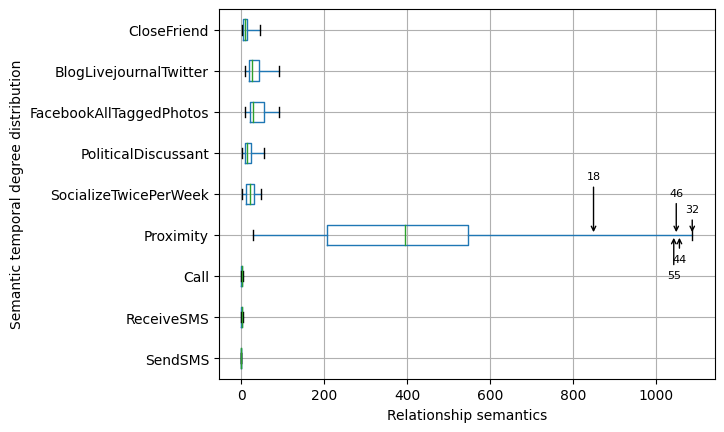

In [129]:
fig, ax2 = plt.subplots()
degree_df.boxplot(ax=ax2,whis=[0,100],vert=False)
ax2.set_xlabel('Relationship semantics') # set x-axis label
ax2.set_ylabel('Semantic temporal degree distribution') # set y-axis label
plt.savefig('myplot.pdf', bbox_inches='tight', format='pdf')
top5 = degree_df.nlargest(5, 'Proximity')['Proximity']
i=0
j=1
for idx, val in top5.items():
    ax2.annotate(f'{idx}', xy=(val, 4), xytext=(val, 4+(0.5+0.2*i)*j),
                ha='center', va='bottom', fontsize=8, arrowprops=dict(facecolor='black', arrowstyle='->'))
    i+=1
    j=-j
plt.savefig('myplot.pdf', bbox_inches='tight', format='pdf')
plt.show(ax2)

EntityId
32    1086.666667
44    1055.833333
46    1048.166667
55    1042.166667
18     848.833333
Name: Proximity, dtype: float64


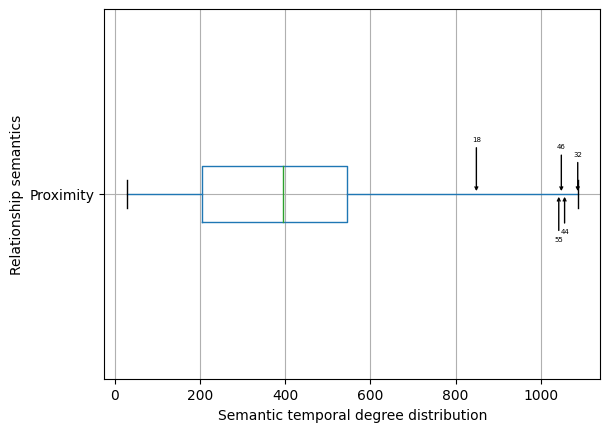

In [118]:
fig1, ax3 = plt.subplots()
df_proximity=pd.DataFrame(degree_df['Proximity'])
df_proximity.boxplot(ax=ax3,whis=[0,100],vert=False)
#ax1.set_xticklabels('Proximity')  # set rotation angle for x-axis labels
ax3.set_ylabel('Relationship semantics') # set x-axis label
ax3.set_xlabel('Semantic temporal degree distribution') # set y-axis label
for col in df_proximity.columns:
    top5 = df_proximity.nlargest(5, col)[col]
    print(top5)
    i=0
    j=1
    for idx, val in top5.items():
        ax3.annotate(f'{idx}', xy=(val, 1), xytext=(val, 1+(0.1+0.01*i)*j),
                    ha='center', va='bottom', fontsize=5, arrowprops=dict(facecolor='black', arrowstyle='->'))
        i+=1
        j=-j
plt.savefig('myplot2.pdf', bbox_inches='tight', format='pdf')
plt.show(ax3)

In [102]:
data_degree_top_5={}
for key, df in data_degree.items():
    new_df = df.iloc[0:5,:]
    data_degree_top_5[key] = new_df

In [103]:
data_degree_top_5

{'Student_d_SendSMS':           SendSMS_Degree  Rank
 EntityId                      
 60                   0.5     1
 30                   0.5     2
 24                   0.5     3
 58                   0.5     4,
 'Student_d_ReceiveSMS':           ReceiveSMS_Degree  Rank
 EntityId                         
 24                     3.25     1
 58                     2.50     2
 31                     0.75     3
 30                     0.25     4
 60                     0.25     5,
 'Student_d_Call':           Call_Degree  Rank
 EntityId                   
 45           4.333333     1
 68           3.666667     2
 79           3.500000     3
 4            3.333333     4
 7            3.166667     5,
 'Student_d_Proximity':           Proximity_Degree  Rank
 EntityId                        
 32             1086.666667     1
 44             1055.833333     2
 46             1048.166667     3
 55             1042.166667     4
 18              848.833333     5,
 'Student_d_SocializeTwicePerWee

In [107]:
df_proximity_top_5=data['Student_d_Proximity'].loc[data_degree_top_5['Student_d_Proximity'].index,:]
df_proximity_top_5

2009-03-05T00:00:00  2009-03-06T00:00:00  2009-03-07T00:00:00  \
EntityId                                                                  
32                      500.0               1472.0                582.0   
44                      790.0                593.0               1120.0   
46                      288.0               1145.0                905.0   
55                      309.0               1843.0                793.0   
18                      603.0               1057.0                  0.0   

          2009-03-08T00:00:00  2009-03-09T00:00:00  2009-03-10T00:00:00  
EntityId                                                                 
32                     1206.0               1292.0               1468.0  
44                     1803.0               1184.0                845.0  
46                     1821.0                906.0               1224.0  
55                      947.0               1841.0                520.0  
18                      383.0               1653.0               1397.0

In [121]:
df_proximity_top_5.columns=['1','2','3','4','5','6']

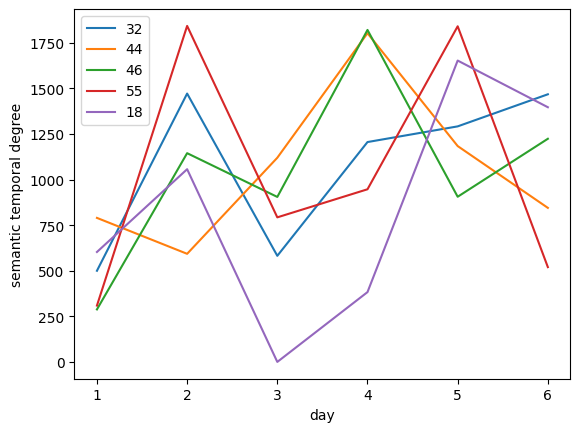

In [122]:
for i in df_proximity_top_5.index:
    df_proximity_top_5.loc[i].plot()
plt.ylabel("semantic temporal degree")
plt.xlabel("day")
plt.legend()
plt.savefig('myplot3.pdf', bbox_inches='tight', format='pdf')
plt.show()